# Event Study of IndianKanoon Rollout
Parse the text of judgements into a dataframe of relevant columns. Adjust the dataframe for the IK rollout by court. Compare the changes in various metrics pre and post IK rollout.  

In [1]:
import os 
import sys
import re
import time
import csv
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ik_parsing as ik
import data_extraction as de
import helper_functions as hp
import defs
from datetime import datetime
from collections import defaultdict
import itertools
import zipfile
import gzip
import json
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt
import math

head, tail = os.path.split(os.getcwd())

In [2]:
import importlib
importlib.reload(ik)
importlib.reload(de)


if __name__ == '__main__':
    start = time.time()
    df = pd.DataFrame()
    courts = ['bombay', 'jharkhand', 'chattisgarh', 'jammu', 'andhra', 'gujarat', 'chennai', 'allahabad', 'himachal_pradesh', 'bangaloredc', 'gauhati']
    dfs = []
                
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(de.extract_data, courts)

    for result in results:
        dfs.append(pd.DataFrame(result))

df = pd.concat(dfs)

print(f"--- {(time.time() - start)} seconds ---")  

print(df.shape)
df.head()

--- 7068.622150421143 seconds ---
(130574, 14)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,judge,banks,cases_cited,acts_cited
0,bombay/1980/100064.txt,NaN,"Commissioner Of Wealth Tax, ... vs Associated ...",1980-03-11,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{M Chandurkar, Sawant}",NaN,"{1862099, 1583419}","{104566, 720619}"
1,bombay/1980/1009377.txt,NaN,"Commissioner Of Income-Tax, ... vs Ramdas Lall...",1980-04-28,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{M Chandurkar, Sawant}",NaN,"{1357456, 645946, 659384, 1381806, 1954990, 54...","{1467536, 104566, 1331148, 909931, 545792, 783..."
2,bombay/1980/1016466.txt,NaN,Cajubhai Balabhai Pradhan vs The State Of Maha...,1980-06-30,Bombay High Court,NaN,NaN,NaN,NaN,NaN,{Rele},NaN,{1331149},"{1679850, 538586}"
3,bombay/1980/1029075.txt,NaN,Talakchand Jayachand Doshi And ... vs Bhaichan...,1980-01-16,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{Jahagirdar, S Manohar}",NaN,"{880376, 481936, 770012, 1453009, 354660, 1433...","{1182132, 427855, 73867, 1317393}"
4,bombay/1980/1029435.txt,NaN,Kishan Thakurdas Gokalani And ... vs Gopichand...,1980-07-02,Bombay High Court,1. this criminal application has been filed un...,NaN,NaN,NaN,NaN,{Mehta},NaN,"{1033301, 1331149, 1328629, 1317063}","{1443301, 621703, 1483303, 1889608, 1679850, 4..."


Takes ~1506 seconds with 500 limit break; took ~3 hours or so for all of MH, JH and CH courts. 
Usually 9-11 hours for all the data in 3 stages. Concat fails on all courts together hence the need for doing it in 3 broken down steps.

Adding more features based on existing columns.

In [26]:
df.reset_index(drop=True, inplace=True)
df['case_id'] = df['file'].apply(lambda x: x[x.rfind('/')+1:-4]) 

citation_counts = hp.citation_count_dict(df)

df['times_cited'] = df['case_id'].apply(lambda x: citation_counts.get(x, 0))

df['bench_size'] = df.loc[:,'judge'].dropna().apply(len)
        
df['num_cases_cited'] = df.loc[:,'cases_cited'].dropna().apply(len)
df['num_acts_cited'] = df.loc[:,'acts_cited'].dropna().apply(len)

df['chief_justice'] = df.loc[:,'judge'].dropna().apply(lambda x: (any('chief' in item for item in x)))

keywords_state = ['state', 'government', 'commissioner', 'national', 'india', 'indian', 'public', 'magistrate',
                  'collector', 'department', 'district']
df['state'] = df.loc[:,'title'].dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_state)))

keywords_business = ['pvt', 'private', 'limited', 'ltd', 'company', 'co.', 'llp', 'llc']
df['business'] = (df.loc[:,'petitioner']+df.loc[:,'respondent']).dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_business)))

keywords_male = ['shri', 'mr.', 'master']

df.replace('\n', ' ', regex = True, inplace = True)
print(df.shape)
df.head()

(52511, 23)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,...,acts_cited,case_id,times_cited,bench_size,num_citations,chief_justice,state,business,num_cases_cited,num_acts_cited
0,bombay/1980/100064.txt,NaN,"Commissioner Of Wealth Tax, ... vs Associated ...",1980-03-11,Bombay High Court,NaN,NaN,NaN,NaN,NaN,...,"{104566, 720619}",100064,0,1.0,2,False,True,NaN,2,2
1,bombay/1980/1009377.txt,NaN,"Commissioner Of Income-Tax, ... vs Ramdas Lall...",1980-04-28,Bombay High Court,NaN,NaN,NaN,NaN,NaN,...,"{1467536, 104566, 1331148, 909931, 545792, 783...",1009377,0,1.0,11,False,True,NaN,11,7
2,bombay/1980/1016466.txt,NaN,Cajubhai Balabhai Pradhan vs The State Of Maha...,1980-06-30,Bombay High Court,NaN,NaN,NaN,NaN,NaN,...,"{1679850, 538586}",1016466,0,1.0,1,False,True,NaN,1,2
3,bombay/1980/1029075.txt,NaN,Talakchand Jayachand Doshi And ... vs Bhaichan...,1980-01-16,Bombay High Court,NaN,NaN,NaN,NaN,NaN,...,"{1182132, 427855, 73867, 1317393}",1029075,0,1.0,13,False,False,NaN,13,4
4,bombay/1980/1029435.txt,NaN,Kishan Thakurdas Gokalani And ... vs Gopichand...,1980-07-02,Bombay High Court,1. this criminal application has been filed un...,NaN,NaN,NaN,NaN,...,"{1443301, 621703, 1483303, 1889608, 1679850, 4...",1029435,0,1.0,4,False,False,NaN,4,7


The number of missing values. Try and get this to around 85-90% and above to proceed. Judges we are extracting at a reasonable accuracy. Next step is to optimize advocates but that is a lot more difficult. Will have to try NER or other approaches. 

In [6]:
df.isna().sum()

file                        0
cnr_num                130574
title                    1504
date                     1504
court                    1504
case_number            119371
petitioner             114882
respondent             114882
petitioner_advocate    126936
respondent_advocate    130395
judge                    4318
banks                  121101
cases_cited                 0
acts_cited                  0
case_id                     0
times_cited                 0
bench_size               4318
num_citations               0
chief_justice            4318
state                    1504
business               114882
dtype: int64

In [44]:
df2.to_pickle('df_11courts1980.pkl')

## Start from Here
We have parsed all the basic case data into the dataframe. Pickle it so that you dont need to run above code every time you start this notebook. Instead you can start from below on. 

In [45]:
df = pd.read_pickle('df_11courts1980.pkl')

# Gujarat dropped because the size of the dataframe is crashing the laptop
df = df[df.court!='Gujarat High Court'].reset_index(drop=True)
df = df[~df.court.isna()]

In [48]:
print(df.court.value_counts())
df.shape

Madras High Court              484344
Jharkhand High Court           338972
Allahabad High Court           236101
Bombay High Court              234271
Himachal Pradesh High Court    132462
Bangalore District Court        67788
Gauhati High Court              66202
Chattisgarh High Court          59361
Jammu & Kashmir High Court      37618
Andhra High Court               22849
Name: court, dtype: int64


(1679968, 22)

In [50]:
df.groupby(df.date.dt.strftime('%Y')).size()

date
1980      1228
1981      1463
1982      1482
1983      1458
1984      1620
1985      1287
1986      1277
1987      1634
1988      1627
1989      1769
1990      2260
1991      2494
1992      2063
1993      2205
1994      2641
1995      2921
1996      3430
1997      4182
1998      4657
1999      4604
2000      3955
2001      4849
2002      8769
2003      8852
2004      8834
2005      8709
2006     12366
2007     12582
2008      9966
2009     12191
2010     83620
2011     45764
2012     49289
2013     39700
2014     67325
2015    155688
2016    146459
2017    203641
2018    282016
2019    469091
dtype: int64

### Upload Dates
Based on Mr. Sinhas email detailing the rollout dates for each court, we creaste additional features to look at the case data and how far it was from the event - the rollout of IK. 

In [51]:
upload_dates = {'Gujarat High Court': datetime.strptime('2010-06-13', '%Y-%m-%d').date(),
                'Jharkhand High Court': datetime.strptime('2010-06-13', '%Y-%m-%d').date(),
                'Himachal Pradesh High Court': datetime.strptime('2017-04-15', '%Y-%m-%d').date(),
                'Allahabad High Court': datetime.strptime('2010-07-18', '%Y-%m-%d').date(),
                'Bangalore District Court': datetime.strptime('2017-02-01', '%Y-%m-%d').date(),
                'Madras High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Bombay High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Gauhati High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date() ,
                'Chattisgarh High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Jammu & Kashmir High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Andhra High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
               }

df['ik_rollout'] = df['court'].apply(lambda x: upload_dates.get(x, np.nan))
df.ik_rollout = pd.to_datetime(df.ik_rollout)
df.loc[:,'days_to_rollout'] = (df.loc[:, 'date'] - df.loc[:, 'ik_rollout'])
df.loc[:,'days_to_rollout'] = df.loc[:,'days_to_rollout'].astype('timedelta64[D]')
# df.loc[df.days_to_update>0,'days_to_update'] = 0
df.loc[:,'months_to_rollout'] = (df.loc[:,'days_to_rollout']/30).apply(math.floor)

In [52]:
print(df.shape)
print(df.columns)
df.head()

(1679968, 25)
Index(['file', 'cnr_num', 'title', 'date', 'court', 'case_number',
       'petitioner', 'respondent', 'petitioner_advocate',
       'respondent_advocate', 'judge', 'banks', 'cases_cited', 'acts_cited',
       'case_id', 'bench_size', 'num_cases_cited', 'num_acts_cited',
       'chief_justice', 'state', 'business', 'times_cited', 'ik_rollout',
       'days_to_rollout', 'months_to_rollout'],
      dtype='object')


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,...,bench_size,num_cases_cited,num_acts_cited,chief_justice,state,business,times_cited,ik_rollout,days_to_rollout,months_to_rollout
0,chennai/2000/1001653.txt,NaN,Combined Engineering Industries ... vs Income ...,2000-11-06,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,1,2,False,False,NaN,0,2009-01-18,-2995.0,-100
1,chennai/2000/1004399.txt,NaN,Arvind C' Bhagat vs Commissioner Of Customs,2000-06-29,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,0,2,False,True,NaN,0,2009-01-18,-3125.0,-105
2,chennai/2000/1004986.txt,NaN,N. Palaniappan vs Government Of Tamil Nadu And...,2000-07-10,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,1,0,False,True,NaN,0,2009-01-18,-3114.0,-104
3,chennai/2000/100594719.txt,NaN,C.Varghees Nadar (Died) vs V.Kamalakshi,2000-04-17,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,2,5,False,False,NaN,0,2009-01-18,-3198.0,-107
4,chennai/2000/1006026.txt,NaN,"Sounder Rajan vs Junior Engineer, Tamil Nadu ...",2000-03-01,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,1,0,False,False,NaN,0,2009-01-18,-3245.0,-109


## Forward Citation
Forward citation is about looking at how the citations in the future of a case changes after the rollout of IK.

Create a dictionary where the key is a caseid that was uploaded on IK after its hearing date (not in realtime) and the value is the date it was uploaded

In [60]:
cases_prior = df.loc[df.date<'01-01-2006',['case_id','ik_rollout']].set_index('case_id').to_dict()['ik_rollout']

In [64]:
df.loc[df.date<'01-01-2006','times_cited'].sum()

42248

In [65]:
df.loc[df.date<'01-01-2006',:].groupby('court').size()

court
Allahabad High Court           15975
Andhra High Court              15946
Bombay High Court              20148
Chattisgarh High Court           479
Gauhati High Court              3755
Himachal Pradesh High Court     1564
Jammu & Kashmir High Court      2232
Jharkhand High Court            4717
Madras High Court              25454
dtype: int64

In [102]:
df_trunc = df.loc[(df.months_to_rollout>-24) & (df.months_to_rollout<48), :]
print(df_trunc.shape)
df_trunc.date.dt.year.value_counts()
# df_trunc.court.value_counts()

(450073, 25)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,...,bench_size,num_cases_cited,num_acts_cited,chief_justice,state,business,times_cited,ik_rollout,days_to_rollout,months_to_rollout
17675,chennai/2007/100020695.txt,NaN,Sankarasubramanian vs Azhaganandham,2007-03-17,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,1,0,False,False,NaN,0,2009-01-18,-673.0,-23
17677,chennai/2007/1000935.txt,NaN,A.Shanmugam vs The District Collector,2007-03-06,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,2.0,0,0,False,True,NaN,0,2009-01-18,-684.0,-23
17678,chennai/2007/1001153.txt,NaN,R.Muthukrishnan vs The State Represented By,2007-10-06,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,4,5,False,True,NaN,0,2009-01-18,-470.0,-16
17679,chennai/2007/1001859.txt,NaN,Madras Can Factory vs The Madras Metropolitan,2007-07-10,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,1.0,0,1,False,False,NaN,0,2009-01-18,-558.0,-19
17680,chennai/2007/1001924.txt,NaN,Subramaniyan vs State Through,2007-03-13,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,2.0,2,3,False,True,NaN,0,2009-01-18,-677.0,-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591298,gauhati/2012/98187906.txt,NaN,Sri Sajal Sarkar @ Sajal Malakar vs The State ...,2012-07-19,Gauhati High Court,"judge, hailakandi in sessions case no. 22/2008...",,,NaN,NaN,...,1.0,2,2,False,True,False,0,2009-01-18,1278.0,42
1591299,gauhati/2012/9842267.txt,NaN,Anil Kumar Bharali vs The State Of Assam And Ors,2012-02-13,Gauhati High Court,NaN,,"- 1. the state of assam, represented ...",NaN,NaN,...,1.0,0,0,False,True,False,1,2009-01-18,1121.0,37
1591300,gauhati/2012/98588236.txt,NaN,M/S. Buildworth Pvt. Ltd vs Labour Court Assam...,2012-08-13,Gauhati High Court,1. that the ref. case no. 06/2010 is ru...,NaN,NaN,NaN,NaN,...,1.0,0,5,False,False,NaN,0,2009-01-18,1303.0,43
1591301,gauhati/2012/98649431.txt,NaN,Harekrishna Dalai vs Smti Sushila Das & Ors,2012-11-30,Gauhati High Court,NaN,,- 1. smti. sushila ...,NaN,NaN,...,1.0,1,1,False,False,False,0,2009-01-18,1412.0,47


In [107]:
res_dict = defaultdict(int)

for row in df_trunc.itertuples():
    for citation in row.cases_cited:
        if citation in cases_prior:
            res_dict[round((row.date-cases_prior[citation]).days/30)] += 1
#             if round((row.date-cases_prior[citation]).days/30)<-100:
#                 print(row.case_id, row.date, cases_prior[citation], citation )

df_es = pd.DataFrame({'months_rollout':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

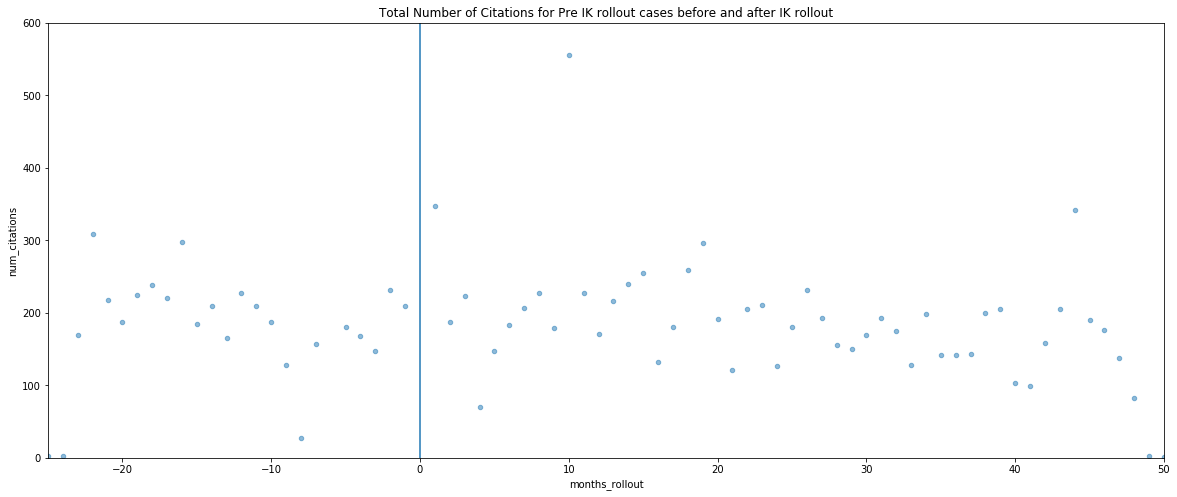

In [109]:
from numpy.polynomial import Polynomial
# df_es.set_index('index', inplace=True)
fig, ax = plt.subplots()
df_es.plot(x='months_rollout', y='num_citations', kind='scatter', ax = ax, figsize=(20,8), alpha=0.5, xlim=(-25,50), ylim=(0,600), title="Total Number of Citations for Pre IK rollout cases before and after IK rollout")
plt.axvline(0)
fig.savefig('plot2.png')
# p = Polynomial.fit(df_es.days, df_es.num_citations, 5)
# plt.plot(*p.linspace())

In [110]:
res_dict = defaultdict(int)

for row in df_trunc.itertuples():
    for citation in row.cases_cited:
        if citation in cases_prior:
            res_dict[round((row.date-cases_prior[citation]).days/30)] += 1

df_es = pd.DataFrame({'months':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

In [111]:
cases_cited_monthly = df_trunc.groupby('months_to_rollout').count()['num_cases_cited'].to_dict()
for key, value in res_dict.items():
    res_dict[key] = res_dict[key]/cases_cited_monthly.get(key, 1)
df_es = pd.DataFrame({'months':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

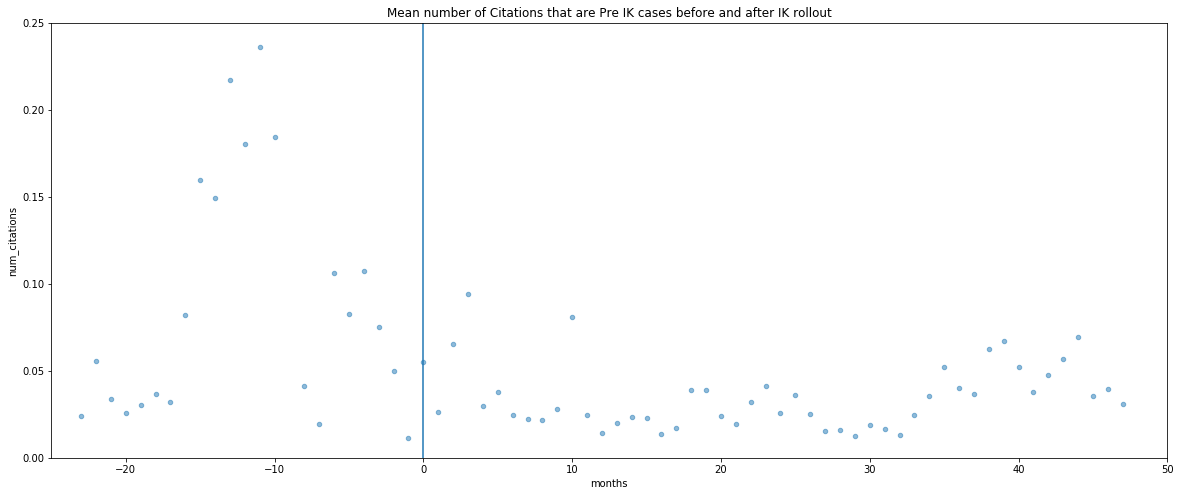

In [113]:
from numpy.polynomial import Polynomial
# df_es.set_index('index', inplace=True)
fig, ax = plt.subplots()
df_es.plot(x='months', y='num_citations', kind='scatter', ax = ax, figsize=(20,8), alpha=0.5, xlim=(-25,50), ylim=(0,0.25), title="Mean number of Citations that are Pre IK cases before and after IK rollout")
plt.axvline(0)
fig.savefig('plot3.png')

In [114]:
res_dict = defaultdict(int)

for row in df_trunc.itertuples():
    for citation in row.acts_cited:
        if citation in cases_prior:
            res_dict[round((row.date-cases_prior[citation]).days/30)] += 1

df_es = pd.DataFrame({'months':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

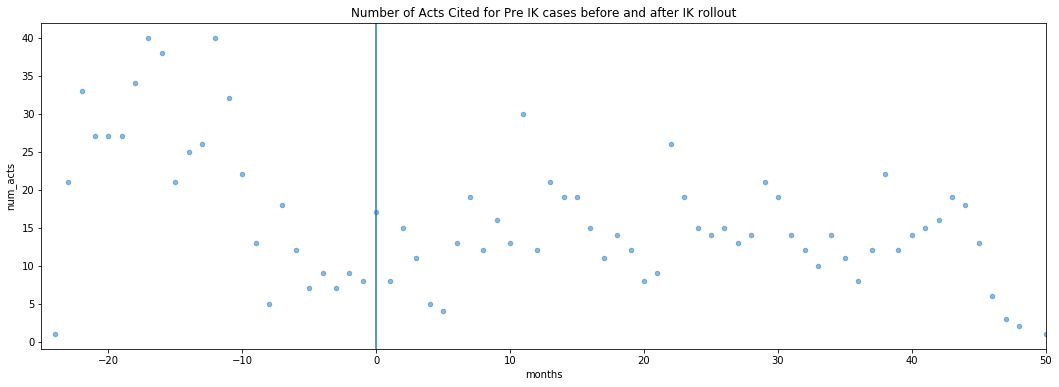

In [116]:
fig, ax = plt.subplots()
df_es_2 = pd.DataFrame({'months':list(res_dict.keys()), 'num_acts':list(res_dict.values())})
df_es_2.plot(x='months', y='num_acts', kind='scatter', ax=ax, figsize=(18,6), xlim = (-25,50), alpha=0.5, title="Number of Acts Cited for Pre IK cases before and after IK rollout")
# p = Polynomial.fit(df_es_2.days, df_es_2.num_acts, 2)
# plt.plot(*p.linspace())
plt.axvline(0)
# fig.savefig('plot3.png')

### Overview
Charting the number of cases and the mean number of citations by month across time based on event specification.

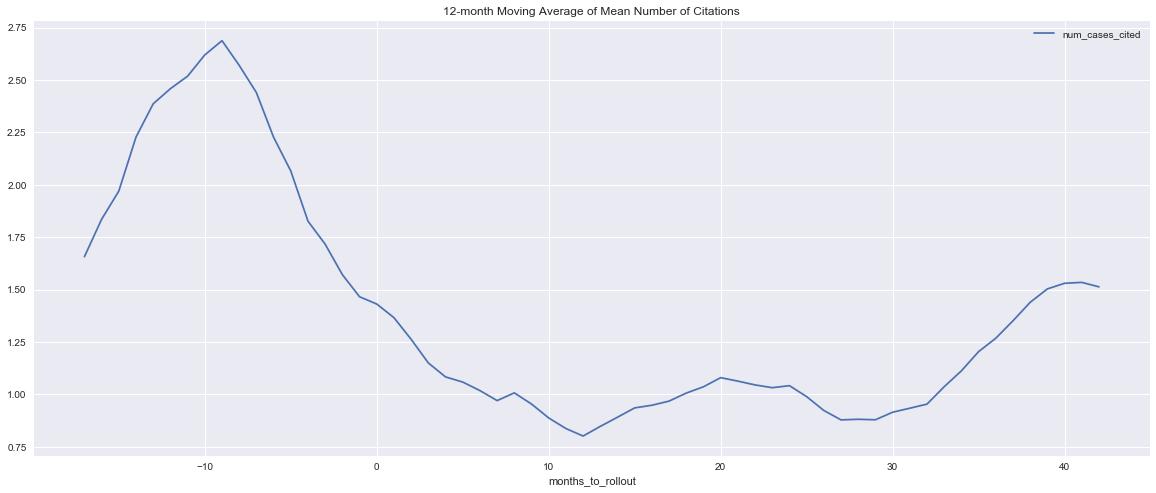

In [118]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
mean_citations_monthly = pd.DataFrame(df_trunc.groupby('months_to_rollout').mean()['num_cases_cited'])
mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,8), ax=ax, title='12-month Moving Average of Mean Number of Citations') #.plot(ax=ax, figsize=(18,6), alpha=0.5, title="Mean number of Citations by Month pre and post IK rollout")

Index(['num_cases_cited'], dtype='object')

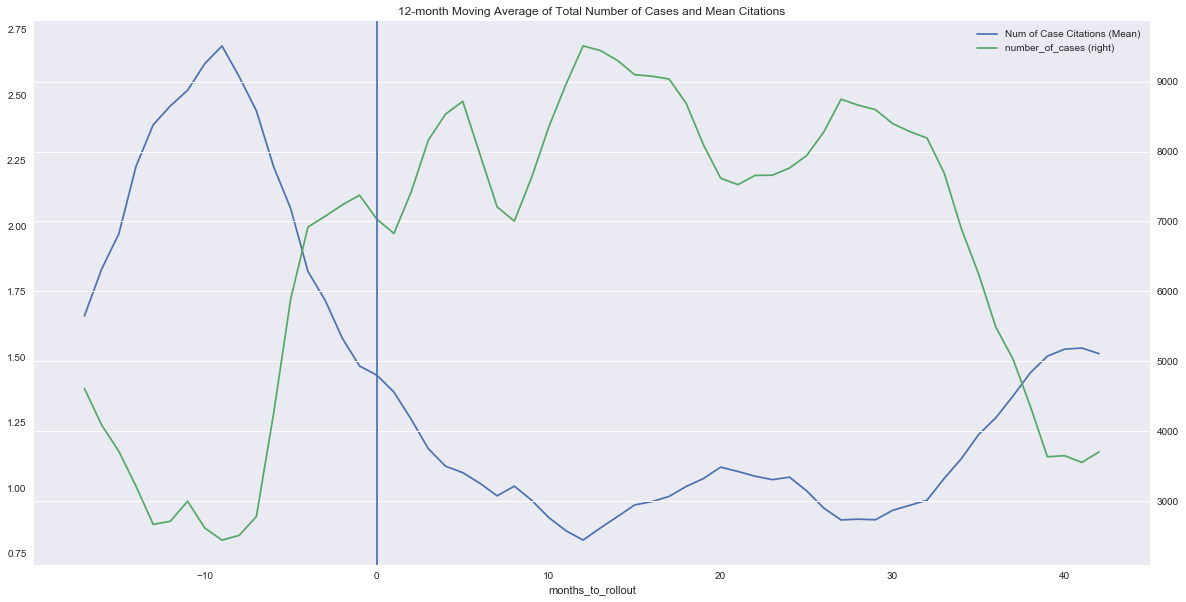

In [122]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
cases_by_time = pd.DataFrame(df_trunc.groupby('months_to_rollout').size())
mean_citations_monthly.columns = ['Num of Case Citations (Mean)']
mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,10), ax=ax) 
cases_by_time.columns = ['number_of_cases']
cases_by_time.rolling(12, center=True).mean().plot(ax=ax, secondary_y=True, title='12-month Moving Average of Total Number of Cases and Mean Citations')
plt.axvline(0)
fig.savefig('plot4.png')
# cases_by_time.plot(figsize=(20,8))

### Citation Diversity

In [142]:
def citation_diversity(df):
    hhi_indices = []
    for year in range(2000, 2020):
        for month in range(1,13):
            citation_counts_year = list(hp.citation_count_dict(df.loc[(df.date.dt.year==year)&(df.date.dt.month==month), :]).values())
            array_p_i = np.array(citation_counts_year)/sum(citation_counts_year)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
    return pd.DataFrame({'date': pd.date_range(start='2000/1/1', end='2019/12/1', freq='MS'), 'citation_diversity_index': hhi_indices})

citation_diversity_bombay = citation_diversity(df) 
citation_diversity_bombay.set_index('date', inplace=True)
citation_diversity_bombay = citation_diversity_bombay.rolling(12, center=True).mean()
citation_diversity_bombay

,citation_diversity_index
date,
2000-01-01,NaN
2000-02-01,NaN
2000-03-01,NaN
2000-04-01,NaN
2000-05-01,NaN
...,...
2019-08-01,NaN
2019-09-01,NaN
2019-10-01,NaN


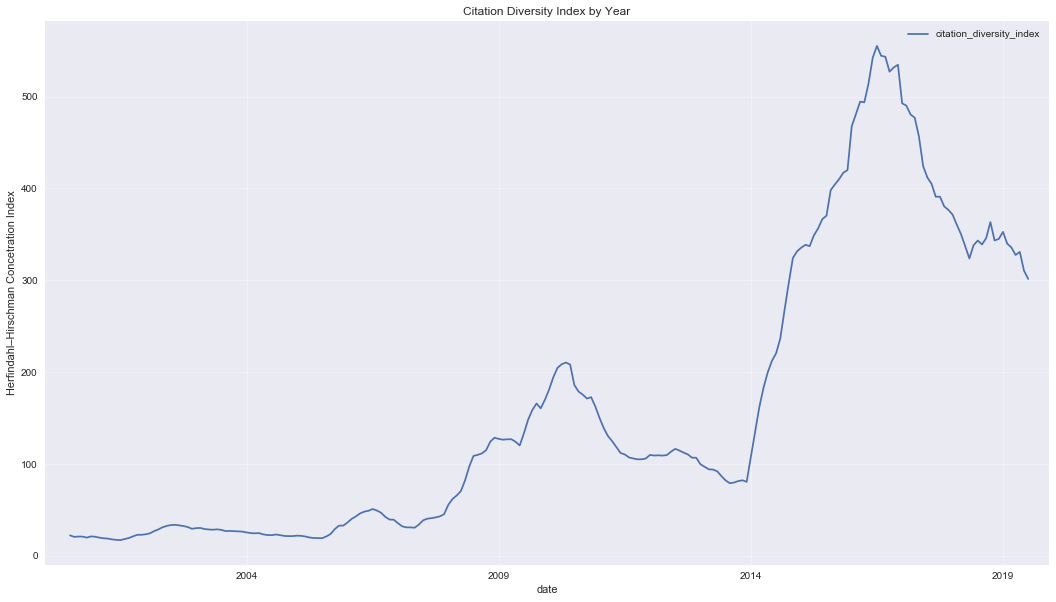

In [143]:
citation_diversity_bombay.index = pd.to_datetime(citation_diversity_bombay.index, format='%B-%Y')
fig, ax = plt.subplots()
plt.style.use('seaborn')
citation_diversity_bombay.plot(figsize=(18,10), ax=ax, title='Citation Diversity Index by Year')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.axvline(0)
plt.savefig('plot5.png')

Citation Diveristy by event specification as opposed to by calender year as shown above.

In [123]:
def citation_diversity_es(df):
    hhi_indices = []
    for month in range(-211, 134):
        citation_counts_month = list(hp.citation_count_dict(df.loc[(df.months_to_rollout==month), :]).values())
        if citation_counts_month:
            array_p_i = np.array(citation_counts_month)/sum(citation_counts_month)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
        else:
            hhi_indices.append(np.nan)
    return pd.DataFrame({'months_rollout': list(range(-211,134)), 'citation_diversity_index': hhi_indices})

citation_diversity_es = citation_diversity_es(df_trunc) 
citation_diversity_es.set_index('months_rollout', inplace=True)
citation_diversity_es = citation_diversity_es.rolling(12, center=True).mean()
citation_diversity_es

,citation_diversity_index
months_rollout,
-211,NaN
-210,NaN
-209,NaN
-208,NaN
-207,NaN
...,...
129,NaN
130,NaN
131,NaN


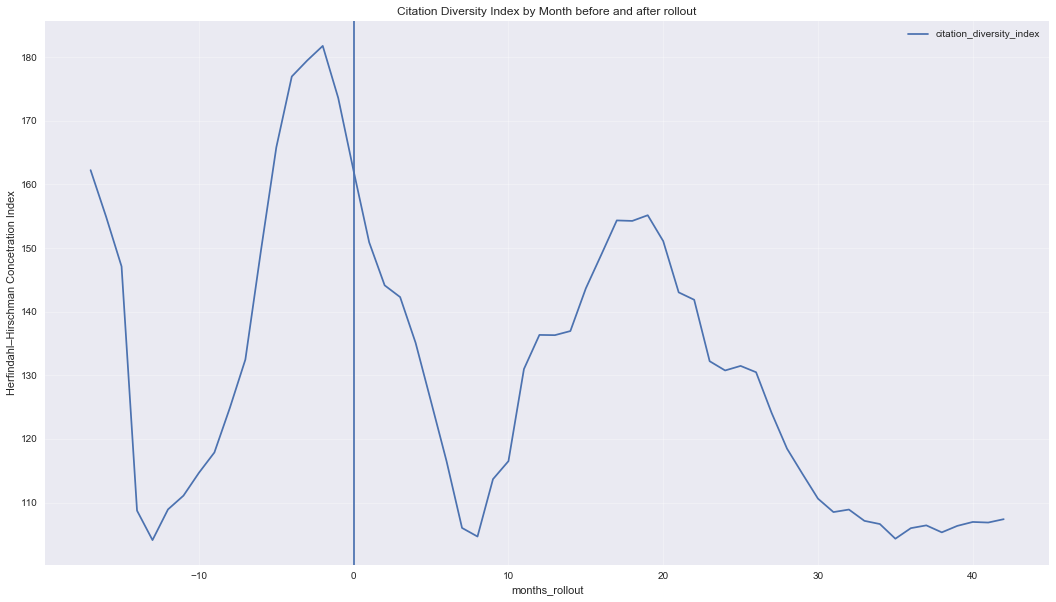

In [125]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
citation_diversity_es.plot(figsize=(18,10), ax=ax, title='Citation Diversity Index by Month before and after rollout')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.axvline(0)
plt.savefig('plot6.png')

### Act Citations Diversity
Perform the same analysis but for citation of acts instead of cases

In [126]:
def act_citation_diversity_es(df):
    hhi_indices = []
    for month in range(-211, 134):
        citation_counts_month = list(hp.acts_citation_count_dict(df.loc[(df.months_to_rollout==month), :]).values())
        if citation_counts_month:
            array_p_i = np.array(citation_counts_month)/sum(citation_counts_month)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
        else:
            hhi_indices.append(np.nan)
    return pd.DataFrame({'months_rollout': list(range(-211,134)), 'citation_diversity_index': hhi_indices})

acts_diversity_es = act_citation_diversity_es(df_trunc) 
acts_diversity_es.set_index('months_rollout', inplace=True)
acts_diversity_es = acts_diversity_es.rolling(12, center=True).mean()
acts_diversity_es

,citation_diversity_index
months_rollout,
-211,NaN
-210,NaN
-209,NaN
-208,NaN
-207,NaN
...,...
129,NaN
130,NaN
131,NaN


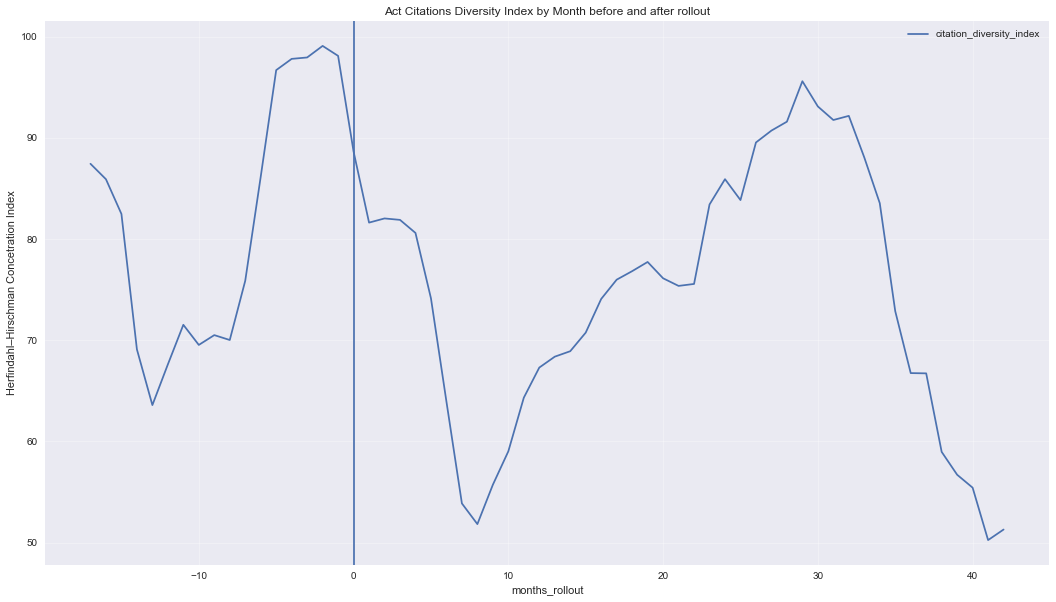

In [128]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
acts_diversity_es.plot(figsize=(18,10), ax=ax, title='Act Citations Diversity Index by Month before and after rollout')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.axvline(0)
plt.savefig('plot7.png')